# 与学习相关的技巧

## Optimizers

### 简单函数

我们先在一个简单的函数上各个优化方法的表现

$$
\begin{aligned}
f(x,y) &= \frac{x^2}{20} + y^2 \\
\frac{\partial f}{\partial x} &= \frac{x}{10}\\
\frac{\partial f}{\partial y} &= 2y
\end{aligned}
$$

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

In [6]:
init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)


SGD:-0.3503929957523197,0.0847823165504322
Momentum:0.9678982568819097,0.0036930078354446005
AdaGrad:-1.897579020383845,2.4414437148905684e-05
Adam:0.1602492509217437,0.1108304639405451


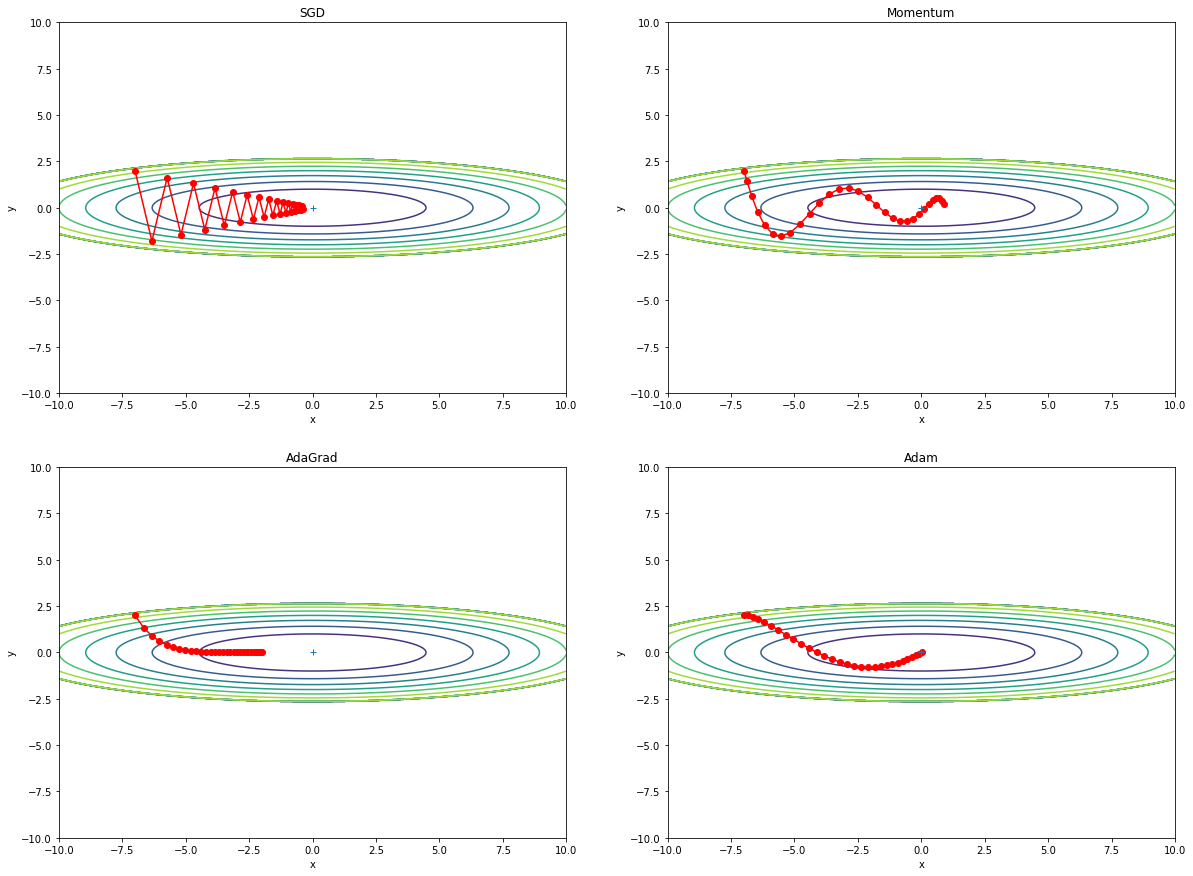

In [12]:
idx = 1
plt.figure(figsize=(20,15))
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    # 输出最终位置
    print(key + ":" + str(params['x']) + "," + str(params['y']))

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### 在mnist数据集上的表现

In [13]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

In [14]:
# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

In [16]:
# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

===========iteration:0===========
SGD:2.3800430108752955
Momentum:2.409262181060683
AdaGrad:2.071980872708461
Adam:2.2133913842180597
===========iteration:100===========
SGD:1.7525127829845153
Momentum:0.5107852688270627
AdaGrad:0.2307917108957499
Adam:0.3281212332953951
===========iteration:200===========
SGD:1.0614414586705911
Momentum:0.2747800077882005
AdaGrad:0.15124725485060603
Adam:0.23035571712381359
===========iteration:300===========
SGD:0.7749639448911005
Momentum:0.2294657726585795
AdaGrad:0.10541311050079887
Adam:0.18104160390805085
===========iteration:400===========
SGD:0.4514699754541438
Momentum:0.1202034991173322
AdaGrad:0.04957631744804124
Adam:0.08082131635717688
===========iteration:500===========
SGD:0.3875683657986833
Momentum:0.19057597767849602
AdaGrad:0.06508642759888303
Adam:0.08157176627665223
===========iteration:600===========
SGD:0.27174458205972807
Momentum:0.1496346262033897
AdaGrad:0.08690059076626998
Adam:0.05971621424466934
===========iteration:700==

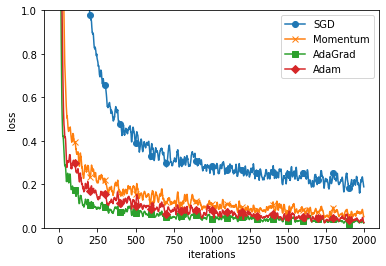

In [17]:
# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


## Weight init

### 观察权重初始化与激活函数值分布的关系

In [18]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

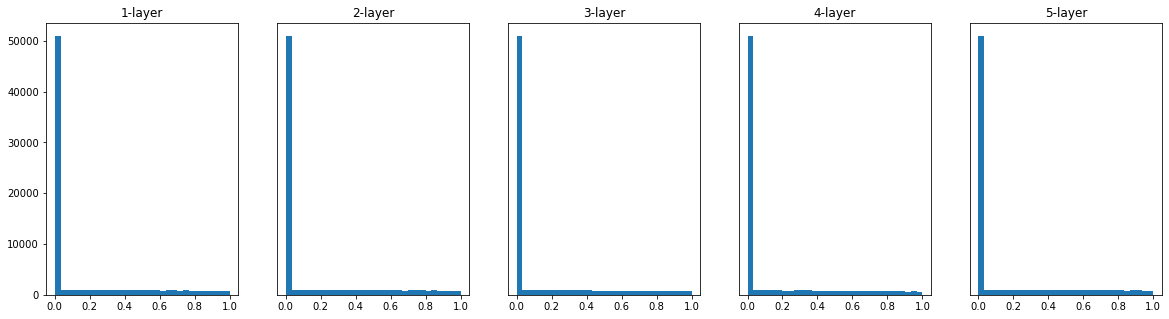

In [44]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
plt.figure(figsize=(20, 5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### 在mnist数据集上的表现

In [45]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

===========iteration:0===========
std=0.01:2.3025337839225903
Xavier:2.2995164290752417
He:2.41387809030843
===========iteration:100===========
std=0.01:2.3019888978415066
Xavier:2.2558808395070566
He:1.3244157298349006
===========iteration:200===========
std=0.01:2.302232382145732
Xavier:2.180233366450169
He:0.6463845726276285
===========iteration:300===========
std=0.01:2.2994267541443705
Xavier:1.9452302570216087
He:0.3971880056228971
===========iteration:400===========
std=0.01:2.3039857459159814
Xavier:1.4255663739421776
He:0.3249629045710516
===========iteration:500===========
std=0.01:2.3018258048379625
Xavier:1.0019682681022575
He:0.3192564893666362
===========iteration:600===========
std=0.01:2.303634988549309
Xavier:0.7312221428487674
He:0.3558864077116604
===========iteration:700===========
std=0.01:2.297219000495313
Xavier:0.5839414030821759
He:0.3553171920138123
===========iteration:800===========
std=0.01:2.301662950951717
Xavier:0.5611544976318557
He:0.2987013197633759
=

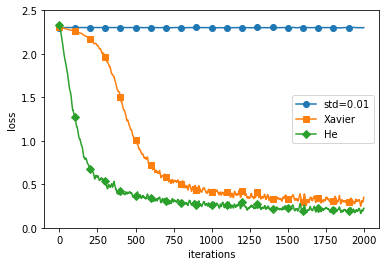

In [46]:


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## Batch Normalization

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 减少学习数据
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

In [2]:
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


============== 1/16 ==============
epoch:0 | 0.117 - 0.12
epoch:1 | 0.097 - 0.142


c:\Users\dongl\Desktop\happy2023\霓虹斋藤带你深度学习入门\【源代码】深度学习入门：基于Python的理论与实现\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
c:\Users\dongl\Desktop\happy2023\霓虹斋藤带你深度学习入门\【源代码】深度学习入门：基于Python的理论与实现\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:2 | 0.097 - 0.175
epoch:3 | 0.097 - 0.195
epoch:4 | 0.097 - 0.206
epoch:5 | 0.097 - 0.224
epoch:6 | 0.097 - 0.249
epoch:7 | 0.097 - 0.262
epoch:8 | 0.097 - 0.289
epoch:9 | 0.097 - 0.302
epoch:10 | 0.097 - 0.318
epoch:11 | 0.097 - 0.34
epoch:12 | 0.097 - 0.344
epoch:13 | 0.097 - 0.355
epoch:14 | 0.097 - 0.362
epoch:15 | 0.097 - 0.376
epoch:16 | 0.097 - 0.389
epoch:17 | 0.097 - 0.399
epoch:18 | 0.097 - 0.416


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.423
============== 2/16 ==============
epoch:0 | 0.093 - 0.119
epoch:1 | 0.097 - 0.136


c:\Users\dongl\Desktop\happy2023\霓虹斋藤带你深度学习入门\【源代码】深度学习入门：基于Python的理论与实现\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
c:\Users\dongl\Desktop\happy2023\霓虹斋藤带你深度学习入门\【源代码】深度学习入门：基于Python的理论与实现\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:2 | 0.097 - 0.166
epoch:3 | 0.097 - 0.187
epoch:4 | 0.097 - 0.21
epoch:5 | 0.097 - 0.233
epoch:6 | 0.097 - 0.266
epoch:7 | 0.097 - 0.281
epoch:8 | 0.097 - 0.296
epoch:9 | 0.097 - 0.318
epoch:10 | 0.097 - 0.336
epoch:11 | 0.097 - 0.364
epoch:12 | 0.097 - 0.39
epoch:13 | 0.097 - 0.408
epoch:14 | 0.097 - 0.428
epoch:15 | 0.097 - 0.444
epoch:16 | 0.097 - 0.466
epoch:17 | 0.097 - 0.49


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.499
epoch:19 | 0.097 - 0.502
============== 3/16 ==============
epoch:0 | 0.098 - 0.147
epoch:1 | 0.323 - 0.174
epoch:2 | 0.446 - 0.186
epoch:3 | 0.537 - 0.21
epoch:4 | 0.6 - 0.231
epoch:5 | 0.67 - 0.275
epoch:6 | 0.696 - 0.303
epoch:7 | 0.744 - 0.344
epoch:8 | 0.776 - 0.369
epoch:9 | 0.808 - 0.4
epoch:10 | 0.811 - 0.43
epoch:11 | 0.839 - 0.445
epoch:12 | 0.866 - 0.482
epoch:13 | 0.872 - 0.502
epoch:14 | 0.886 - 0.514
epoch:15 | 0.891 - 0.518
epoch:16 | 0.905 - 0.551
epoch:17 | 0.924 - 0.568
epoch:18 | 0.923 - 0.587


No handles with labels found to put in legend.


epoch:19 | 0.936 - 0.592
============== 4/16 ==============
epoch:0 | 0.074 - 0.093
epoch:1 | 0.161 - 0.135
epoch:2 | 0.289 - 0.174
epoch:3 | 0.399 - 0.245
epoch:4 | 0.465 - 0.315
epoch:5 | 0.528 - 0.391
epoch:6 | 0.577 - 0.457
epoch:7 | 0.629 - 0.523
epoch:8 | 0.659 - 0.578
epoch:9 | 0.685 - 0.603
epoch:10 | 0.718 - 0.643
epoch:11 | 0.719 - 0.672
epoch:12 | 0.748 - 0.69
epoch:13 | 0.767 - 0.712
epoch:14 | 0.789 - 0.726
epoch:15 | 0.805 - 0.738
epoch:16 | 0.817 - 0.752
epoch:17 | 0.822 - 0.774


No handles with labels found to put in legend.


epoch:18 | 0.838 - 0.779
epoch:19 | 0.846 - 0.795
============== 5/16 ==============
epoch:0 | 0.077 - 0.102
epoch:1 | 0.08 - 0.119
epoch:2 | 0.082 - 0.254
epoch:3 | 0.087 - 0.377
epoch:4 | 0.102 - 0.464
epoch:5 | 0.114 - 0.534
epoch:6 | 0.135 - 0.586
epoch:7 | 0.153 - 0.633
epoch:8 | 0.163 - 0.674
epoch:9 | 0.18 - 0.706
epoch:10 | 0.186 - 0.747
epoch:11 | 0.201 - 0.767
epoch:12 | 0.213 - 0.797
epoch:13 | 0.216 - 0.822
epoch:14 | 0.233 - 0.83
epoch:15 | 0.243 - 0.845
epoch:16 | 0.268 - 0.861
epoch:17 | 0.284 - 0.876
epoch:18 | 0.303 - 0.881


No handles with labels found to put in legend.


epoch:19 | 0.31 - 0.883
============== 6/16 ==============
epoch:0 | 0.105 - 0.123
epoch:1 | 0.093 - 0.267
epoch:2 | 0.101 - 0.502
epoch:3 | 0.11 - 0.606
epoch:4 | 0.109 - 0.653
epoch:5 | 0.104 - 0.698
epoch:6 | 0.108 - 0.732
epoch:7 | 0.117 - 0.758
epoch:8 | 0.112 - 0.786
epoch:9 | 0.121 - 0.812
epoch:10 | 0.154 - 0.836
epoch:11 | 0.121 - 0.861
epoch:12 | 0.117 - 0.874
epoch:13 | 0.121 - 0.891
epoch:14 | 0.151 - 0.906
epoch:15 | 0.117 - 0.915
epoch:16 | 0.116 - 0.926
epoch:17 | 0.116 - 0.938


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.952
epoch:19 | 0.116 - 0.957
============== 7/16 ==============
epoch:0 | 0.105 - 0.096
epoch:1 | 0.105 - 0.292
epoch:2 | 0.109 - 0.528
epoch:3 | 0.117 - 0.67
epoch:4 | 0.117 - 0.72
epoch:5 | 0.117 - 0.773
epoch:6 | 0.117 - 0.806
epoch:7 | 0.117 - 0.844
epoch:8 | 0.117 - 0.871
epoch:9 | 0.117 - 0.903
epoch:10 | 0.117 - 0.927
epoch:11 | 0.117 - 0.945
epoch:12 | 0.117 - 0.948
epoch:13 | 0.117 - 0.962
epoch:14 | 0.117 - 0.965
epoch:15 | 0.117 - 0.972
epoch:16 | 0.117 - 0.974
epoch:17 | 0.123 - 0.977
epoch:18 | 0.117 - 0.978


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.982
============== 8/16 ==============
epoch:0 | 0.087 - 0.09
epoch:1 | 0.117 - 0.465
epoch:2 | 0.116 - 0.743
epoch:3 | 0.116 - 0.838
epoch:4 | 0.116 - 0.868
epoch:5 | 0.116 - 0.907
epoch:6 | 0.116 - 0.938
epoch:7 | 0.116 - 0.95
epoch:8 | 0.116 - 0.961
epoch:9 | 0.116 - 0.974
epoch:10 | 0.116 - 0.985
epoch:11 | 0.116 - 0.986
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.993
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.998
epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.092 - 0.101
epoch:1 | 0.116 - 0.45
epoch:2 | 0.116 - 0.628
epoch:3 | 0.116 - 0.762
epoch:4 | 0.117 - 0.841
epoch:5 | 0.117 - 0.896
epoch:6 | 0.117 - 0.95
epoch:7 | 0.117 - 0.968
epoch:8 | 0.117 - 0.985
epoch:9 | 0.117 - 0.988
epoch:10 | 0.117 - 0.986
epoch:11 | 0.116 - 0.995
epoch:12 | 0.116 - 0.996
epoch:13 | 0.116 - 0.998
epoch:14 | 0.116 - 1.0
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.097 - 0.083
epoch:1 | 0.116 - 0.621
epoch:2 | 0.117 - 0.797
epoch:3 | 0.117 - 0.861
epoch:4 | 0.117 - 0.813
epoch:5 | 0.117 - 0.863
epoch:6 | 0.117 - 0.928
epoch:7 | 0.117 - 0.945
epoch:8 | 0.117 - 0.976
epoch:9 | 0.117 - 0.986
epoch:10 | 0.117 - 0.963
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.1 - 0.172
epoch:1 | 0.116 - 0.607
epoch:2 | 0.117 - 0.691
epoch:3 | 0.105 - 0.684
epoch:4 | 0.105 - 0.813
epoch:5 | 0.116 - 0.857
epoch:6 | 0.116 - 0.877
epoch:7 | 0.116 - 0.962
epoch:8 | 0.116 - 0.898
epoch:9 | 0.116 - 0.943
epoch:10 | 0.116 - 0.977
epoch:11 | 0.116 - 0.865
epoch:12 | 0.117 - 0.966
epoch:13 | 0.117 - 0.984
epoch:14 | 0.117 - 0.99
epoch:15 | 0.117 - 0.991
epoch:16 | 0.117 - 0.993
epoch:17 | 0.117 - 0.985
epoch:18 | 0.117 - 0.993


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.992
============== 12/16 ==============
epoch:0 | 0.117 - 0.14
epoch:1 | 0.117 - 0.406
epoch:2 | 0.117 - 0.572
epoch:3 | 0.117 - 0.614
epoch:4 | 0.117 - 0.539
epoch:5 | 0.117 - 0.667
epoch:6 | 0.117 - 0.672
epoch:7 | 0.117 - 0.697
epoch:8 | 0.117 - 0.696
epoch:9 | 0.117 - 0.698
epoch:10 | 0.117 - 0.704
epoch:11 | 0.117 - 0.705
epoch:12 | 0.117 - 0.693
epoch:13 | 0.117 - 0.706
epoch:14 | 0.117 - 0.719
epoch:15 | 0.117 - 0.711
epoch:16 | 0.117 - 0.799
epoch:17 | 0.117 - 0.793


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.801
epoch:19 | 0.117 - 0.805
============== 13/16 ==============
epoch:0 | 0.094 - 0.128
epoch:1 | 0.116 - 0.395
epoch:2 | 0.116 - 0.441
epoch:3 | 0.116 - 0.566
epoch:4 | 0.116 - 0.652
epoch:5 | 0.117 - 0.655
epoch:6 | 0.117 - 0.637
epoch:7 | 0.117 - 0.653
epoch:8 | 0.117 - 0.673
epoch:9 | 0.117 - 0.68
epoch:10 | 0.117 - 0.663
epoch:11 | 0.117 - 0.703
epoch:12 | 0.117 - 0.712
epoch:13 | 0.117 - 0.716
epoch:14 | 0.117 - 0.715
epoch:15 | 0.117 - 0.711
epoch:16 | 0.117 - 0.718
epoch:17 | 0.117 - 0.717
epoch:18 | 0.117 - 0.716


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.717
============== 14/16 ==============
epoch:0 | 0.116 - 0.099
epoch:1 | 0.116 - 0.369
epoch:2 | 0.116 - 0.469
epoch:3 | 0.116 - 0.559
epoch:4 | 0.116 - 0.565
epoch:5 | 0.116 - 0.592
epoch:6 | 0.116 - 0.588
epoch:7 | 0.116 - 0.606
epoch:8 | 0.116 - 0.549
epoch:9 | 0.116 - 0.61
epoch:10 | 0.116 - 0.607
epoch:11 | 0.116 - 0.605
epoch:12 | 0.116 - 0.606
epoch:13 | 0.116 - 0.612
epoch:14 | 0.116 - 0.62
epoch:15 | 0.116 - 0.622
epoch:16 | 0.116 - 0.621
epoch:17 | 0.116 - 0.621


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.614
epoch:19 | 0.116 - 0.622
============== 15/16 ==============
epoch:0 | 0.116 - 0.184
epoch:1 | 0.116 - 0.317
epoch:2 | 0.116 - 0.419
epoch:3 | 0.116 - 0.464
epoch:4 | 0.116 - 0.496
epoch:5 | 0.116 - 0.455
epoch:6 | 0.116 - 0.526
epoch:7 | 0.116 - 0.5
epoch:8 | 0.116 - 0.521
epoch:9 | 0.116 - 0.52
epoch:10 | 0.117 - 0.523
epoch:11 | 0.117 - 0.52
epoch:12 | 0.117 - 0.522
epoch:13 | 0.116 - 0.524
epoch:14 | 0.116 - 0.524
epoch:15 | 0.116 - 0.525
epoch:16 | 0.116 - 0.493
epoch:17 | 0.117 - 0.499


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.52
epoch:19 | 0.116 - 0.523
============== 16/16 ==============
epoch:0 | 0.093 - 0.095
epoch:1 | 0.117 - 0.223
epoch:2 | 0.117 - 0.3
epoch:3 | 0.116 - 0.31
epoch:4 | 0.116 - 0.314
epoch:5 | 0.116 - 0.395
epoch:6 | 0.116 - 0.379
epoch:7 | 0.116 - 0.405
epoch:8 | 0.116 - 0.411
epoch:9 | 0.117 - 0.423
epoch:10 | 0.117 - 0.415
epoch:11 | 0.117 - 0.412
epoch:12 | 0.117 - 0.414
epoch:13 | 0.117 - 0.407
epoch:14 | 0.117 - 0.415
epoch:15 | 0.117 - 0.413
epoch:16 | 0.117 - 0.415
epoch:17 | 0.117 - 0.414
epoch:18 | 0.117 - 0.42
epoch:19 | 0.117 - 0.425


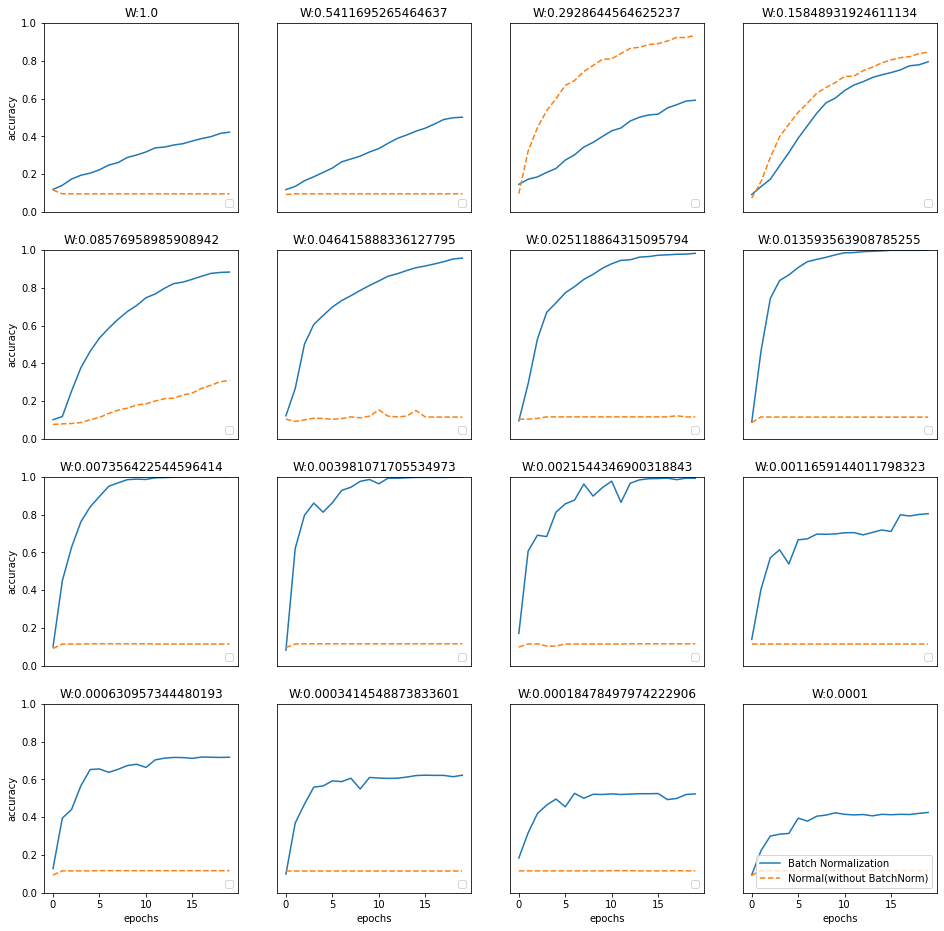

In [4]:

# 3.绘制图形==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)
plt.figure(figsize=(16, 16))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

## 正则化

### 过拟合

epoch:0, train acc:0.10666666666666667, test acc:0.105
epoch:1, train acc:0.12, test acc:0.1095
epoch:2, train acc:0.14, test acc:0.1167
epoch:3, train acc:0.15666666666666668, test acc:0.1253
epoch:4, train acc:0.17333333333333334, test acc:0.1379
epoch:5, train acc:0.2, test acc:0.1526
epoch:6, train acc:0.24666666666666667, test acc:0.1694
epoch:7, train acc:0.27, test acc:0.192
epoch:8, train acc:0.2866666666666667, test acc:0.2075
epoch:9, train acc:0.30333333333333334, test acc:0.2317
epoch:10, train acc:0.33, test acc:0.2509
epoch:11, train acc:0.34, test acc:0.2669
epoch:12, train acc:0.38333333333333336, test acc:0.2882
epoch:13, train acc:0.38333333333333336, test acc:0.3074
epoch:14, train acc:0.3933333333333333, test acc:0.298
epoch:15, train acc:0.38666666666666666, test acc:0.3048
epoch:16, train acc:0.39666666666666667, test acc:0.3059
epoch:17, train acc:0.4166666666666667, test acc:0.3154
epoch:18, train acc:0.4266666666666667, test acc:0.322
epoch:19, train acc:0.4366

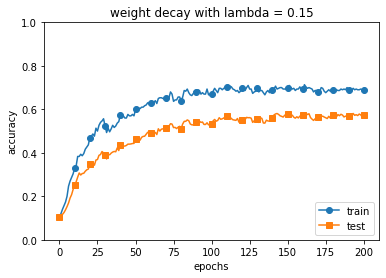

In [11]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（权值衰减）的设定 =======================
# weight_decay_lambda = 0 # 不使用权值衰减的情况
weight_decay_lambda = 0.15
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("weight decay with lambda = " + str(weight_decay_lambda))
plt.savefig("weight_decay_lambda_" + str(weight_decay_lambda) + ".png")

In [14]:
%%HTML
<img src="weight_decay_lambda_0.png" width="500">
<img src="weight_decay_lambda_0.1.png" width="500">
<img src="weight_decay_lambda_0.15.png" width="500">
<img src="weight_decay_lambda_0.2.png" width="500">


> lambda调大了会导致欠拟合

## Dropout

就相当于每次会忘记一些神经元，这样的最终效果一定程度上可以实现集成学习的效果

train loss:2.302758376019015
=== epoch:1, train acc:0.1, test acc:0.0883 ===
train loss:2.2963361698444165
train loss:2.300879916925805
train loss:2.2921698868704903
=== epoch:2, train acc:0.10666666666666667, test acc:0.0899 ===
train loss:2.300843504772969
train loss:2.2999652429852606
train loss:2.295441251897368
=== epoch:3, train acc:0.10666666666666667, test acc:0.0913 ===
train loss:2.2928238896505015
train loss:2.2996653635555133
train loss:2.3014190234647023
=== epoch:4, train acc:0.10666666666666667, test acc:0.0938 ===
train loss:2.2949696035830125
train loss:2.2955400695924273
train loss:2.290127458679801
=== epoch:5, train acc:0.11333333333333333, test acc:0.0927 ===
train loss:2.29836544515542
train loss:2.3013050580272143
train loss:2.295506654609889
=== epoch:6, train acc:0.10666666666666667, test acc:0.093 ===
train loss:2.3025982848287008
train loss:2.298038084996331
train loss:2.2948917717586155
=== epoch:7, train acc:0.11666666666666667, test acc:0.0956 ===
train lo

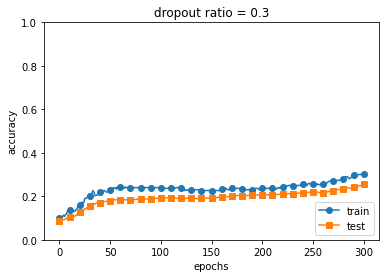

In [23]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# 设定是否使用Dropuout，以及比例 ========================
use_dropout = True  # 不使用Dropout的情况下为False
dropout_ratio = 0.3
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("dropout ratio = " + str(dropout_ratio))
plt.savefig("dropout_ratio_" + str(dropout_ratio) + ".png")

In [25]:
%%HTML
<img src="dropout_ratio_0.png" width="500">
<img src="dropout_ratio_0.1.png" width="500">
<img src="dropout_ratio_0.15.png" width="500">
<img src="dropout_ratio_0.2.png" width="500">
<img src="dropout_ratio_0.3.png" width="500">
<img src="dropout_ratio_0.5.png" width="500">

## 超参数的选择

- 交叉验证
- 网格搜索
- 随机搜索
- 贝叶斯优化


val acc:0.09 | lr:2.8701393875908424e-06, weight decay:6.140172896890032e-07
val acc:0.13 | lr:1.4912511721995731e-05, weight decay:9.5091187270814e-06
val acc:0.11 | lr:3.0580124762552806e-06, weight decay:2.4500520975667796e-07
val acc:0.11 | lr:4.6561725615042536e-05, weight decay:6.00598332667672e-07
val acc:0.16 | lr:1.0855452787705814e-05, weight decay:1.920975977573137e-06
val acc:0.13 | lr:1.3367338991345341e-06, weight decay:3.0480889244389142e-05
val acc:0.61 | lr:0.002833884044623603, weight decay:2.2611629745040746e-08
val acc:0.09 | lr:0.000129327828026089, weight decay:2.35070035826472e-08
val acc:0.07 | lr:4.806419566211608e-06, weight decay:6.261210266841015e-08
val acc:0.12 | lr:7.898843770536545e-05, weight decay:5.996834468184481e-08
val acc:0.14 | lr:0.0006029613043907551, weight decay:1.1491846718045895e-06
val acc:0.16 | lr:0.000602802729942073, weight decay:2.663590347733878e-06
val acc:0.12 | lr:9.307257940807537e-06, weight decay:9.796653839382743e-06
val acc:0

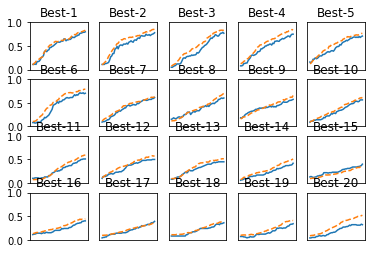

In [26]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 超参数的随机搜索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 指定搜索的超参数的范围===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list


=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.8) | lr:0.006355475195543364, weight decay:1.5935350311812534e-07
Best-2(val acc:0.78) | lr:0.0069607440767239315, weight decay:2.0702317984213303e-06
Best-3(val acc:0.77) | lr:0.007429263145622613, weight decay:2.2628616943905394e-07
Best-4(val acc:0.75) | lr:0.006995706343916105, weight decay:4.6702440220174375e-06
Best-5(val acc:0.71) | lr:0.004811269954270873, weight decay:3.260296333559403e-08
Best-6(val acc:0.7) | lr:0.006337440387474254, weight decay:5.608869457536081e-05
Best-7(val acc:0.61) | lr:0.002833884044623603, weight decay:2.2611629745040746e-08
Best-8(val acc:0.6) | lr:0.003611127865435481, weight decay:1.897238855233528e-07
Best-9(val acc:0.57) | lr:0.004336833589169533, weight decay:6.512222124434863e-07
Best-10(val acc:0.56) | lr:0.0030129454522774385, weight decay:1.4871677578103648e-08
Best-11(val acc:0.51) | lr:0.0025567062215304517, weight decay:6.011210305167521e-08
Best-12(val acc:0.5

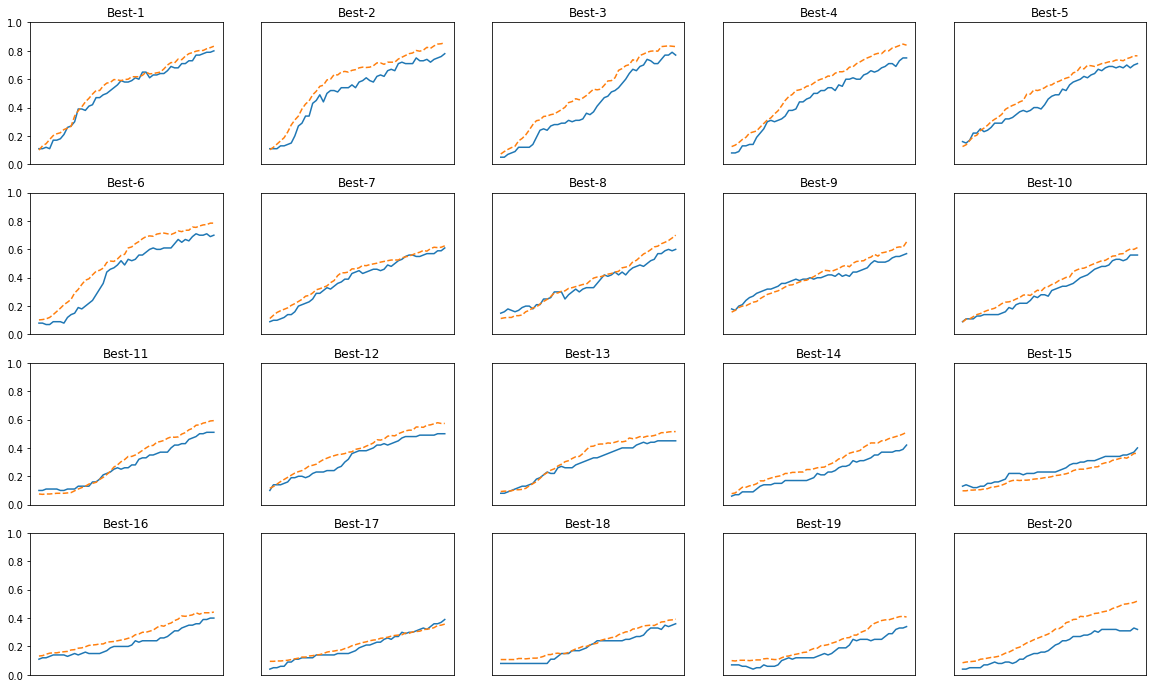

In [30]:

# 绘制图形========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(20, 12))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()
